In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import pathmagic
from tools.project import proj_dir

In [2]:
import torch
from net.super_slomo_net import SuperSlomoNet, SuperSlomoNetDummy
from trainer.super_slomo_trainer import SuperSlomoTrainer
import numpy as np

from data import SuperSlomoData, DatasetSubset

device = "cuda:0"
#device = "cpu"

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

train_data = SuperSlomoData(proj_dir("datasets"), "train")
val_data = SuperSlomoData(proj_dir("datasets"), "val")

train_data = DatasetSubset(train_data, range(0, 3))
val_data = DatasetSubset(train_data, range(0, 1))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                           shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                         shuffle=True, num_workers=1)

#model = SuperSlomoNet(352, 352, device).to(device)
model = SuperSlomoNetDummy(352, 352, device).to(device)

optimizer = torch.optim.Adam(params=model.parameters())
trainer = SuperSlomoTrainer(model, device, optimizer)

#trainer.train(train_loader, val_loader)

Not preloading data.
Not preloading data.


/home/kevin/.virtualenvs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU0 GeForce GTX 660M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
#trainer.train(train_loader, val_loader)

In [4]:
import torch

A = torch.rand(5, 4, 16, 16) # N C W H
t = torch.rand(5) # N

out1 = t[:,None,None,None] * A

out2 = torch.zeros(5, 4, 16, 16)

for i in range(5):
    out2[i] = t[i] * A[i]
    
print(torch.sum((out1 - out2)**2))

tensor(0.)


In [5]:
import torch
from net.super_slomo_net import SuperSlomoNet, SuperSlomoNetDummy

device = "cpu"
model = SuperSlomoNet(352, 352, device).to(device)

print(model.timesteps)
print(len(list(model.parameters())))

tensor([0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750])
92


In [6]:
import torch
from data import SuperSlomoData
from net.super_slomo_net import BackWarp
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(123)
random.seed(123)

def show_tensor(x):
    plt.imshow(x[0].permute(1, 2, 0))

def show_flow(fl):
    show_tensor(torch.cat([fl[:,:2,:,:], torch.zeros_like(fl[:,:2,:,:])], dim=1))
    
w, h = 640, 360
#w, h = 352, 352
    
#backwarp = BackWarp(h, w, "cpu")

train_data = SuperSlomoData(proj_dir("datasets"), "train", transform_data=False)

img_pair = train_data[0][0][0]

img = img_pair[:3]
img2 = img_pair[3:]
img = img[:, :h, :w]

print(img.size())

flow_u = torch.Tensor(h, w)
flow_v = torch.Tensor(h, w)

_ = img.unsqueeze_(0)

Not preloading data.
torch.Size([3, 360, 640])


In [13]:
backwarp = BackWarp(w, h, "cpu")

flow_u.fill_(-100)
flow_v.fill_(-50)
flow = torch.stack([flow_u, flow_v]).unsqueeze(0)

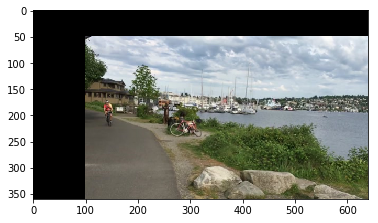

In [14]:
img_warped = backwarp(img, flow)
show_tensor(img_warped)

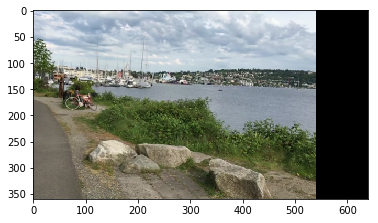

In [9]:
import torch

class BackWarpAvi(torch.nn.Module):
    def __init__(self, W, H, device):
        super().__init__()
        # create a grid
        gridX, gridY = np.meshgrid(np.arange(W), np.arange(H))
        self.W = W
        self.H = H
        self.gridX = torch.tensor(gridX, requires_grad=False, device=device)
        self.gridY = torch.tensor(gridY, requires_grad=False, device=device)
        
    def forward(self, img, flow):
        # Extract horizontal and vertical flows.
        u = flow[:, 0, :, :]
        v = flow[:, 1, :, :]
        x = self.gridX.unsqueeze(0).expand_as(u).float() + u
        y = self.gridY.unsqueeze(0).expand_as(v).float() + v
        # range -1 to 1
        x = 2*(x/self.W - 0.5)
        y = 2*(y/self.H - 0.5)
        # stacking X and Y
        grid = torch.stack((x,y), dim=3)
        # Sample pixels using bilinear interpolation.
        imgOut = torch.nn.functional.grid_sample(img, grid)
        return imgOut
    
flow_u.fill_(100)
flow_v.fill_(0)
flow = torch.stack([flow_u, flow_v]).unsqueeze(0)
    
backwarp_avi = BackWarpAvi(w, h, "cpu")

img_warped2 = backwarp_avi(img, flow)
show_tensor(img_warped2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


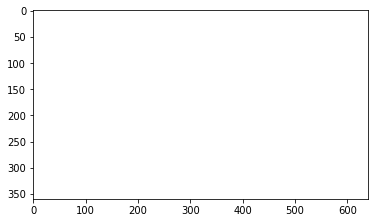

In [10]:
show_flow(flow)

In [11]:
fl_res = model.compute_flow_t([2], flow, 2*flow)

In [12]:
print((fl_res[0]).max())

tensor(4.6875)
